In [4]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
info = get_info(kind='biosemi32')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


Using control points [0.00000000e+00 1.89501583e-05 2.06292083e-03]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

No projector specified for this dataset. Please consider the method self.add_proj.


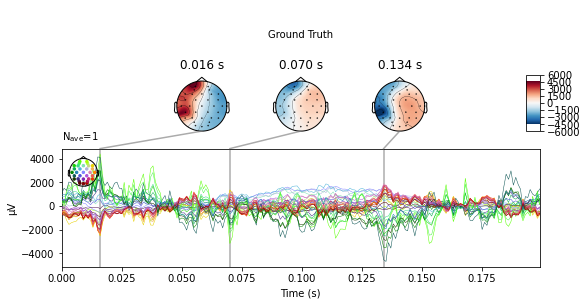

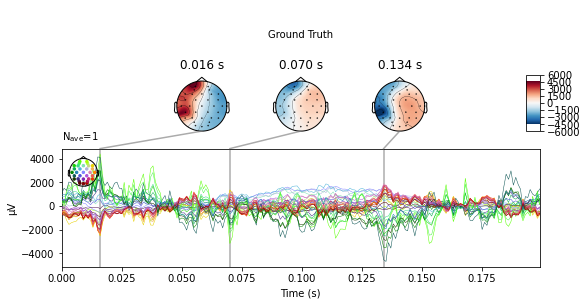

Using control points [0.09054835 0.10276585 0.20371258]
Using control points [0.09054835 0.10276585 0.20371258]


In [67]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=10,
    n_orders=(0, 3),
    snr_range=(50, 51),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False)

gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Algo

In [65]:
# from copy import deepcopy
# from scipy.sparse import csr_matrix
# from scipy.linalg import sqrtm
# Y = deepcopy(evoked.data)
# L = deepcopy(leadfield)
# Y_scaled = deepcopy(Y)
# scaler = abs(Y_scaled).mean()
# Y_scaled /= scaler

# n_chans, n_dipoles = leadfield.shape
# n_times = Y.shape[1]
# # Params
# max_iter = 300
# alpha = 0

# # Prepare matrices
# I = np.identity(n_chans)
# gammas = np.ones(n_dipoles)
# Gamma = csr_matrix(np.diag(gammas))

# Cb =  Y@Y.T / n_times + alpha*np.identity(n_chans)
# sigma_eps = I*alpha
# for i in range(max_iter):
#     print("iter ", i)
#     sigma_y = L @ Gamma @ L.T + sigma_eps
#     sigma_y_inv = np.linalg.inv(sigma_y)
#     X_new = Gamma @ L.T @ sigma_y_inv @ Y_scaled
#     Z_new = L.T @ sigma_y_inv @ L
#     Z_sqrt = sqrtm(Z_new)
#     Z_sqrt_inv = np.linalg.inv(Z_sqrt)
#     old_Gamma = deepcopy(Gamma)
#     Gamma = csr_matrix(Z_sqrt_inv @ sqrtm(Z_sqrt @ X_new @ X_new.T @ Z_sqrt) @ Z_sqrt_inv)
#     # gammas = np.sqrt(np.mean(X_new**2, axis=1) / np.diag(L.T @ Sigma_y_inv @ L))
#     Gamma = csr_matrix(np.diag(gammas))
#     print("change: ", np.mean(abs(np.diag(old_Gamma.toarray())-np.diag(Gamma.toarray()))))

Sigma_y = scaler*I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
inverse_operator = Gamma @ L.T @ Sigma_y_inv
X = inverse_operator @ Y
# update rule (16)


In [66]:
stc_ = stc.copy()
stc_.data = np.real(X)
stc_.data /= abs(stc_.data).max()
stc_.plot(**pp)

Using control points [0.12521494 0.15183934 0.4727879 ]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



Using control points [0.09054835 0.10276585 0.20371258]


In [39]:
X

array([[-0.13081814-1.61655506e-07j,  0.10570432-1.86981011e-07j,
         0.09340715-1.88148586e-07j, ...,  0.15263792-1.61726012e-07j,
        -0.09016386-1.62288271e-07j,  0.0266072 -1.42227455e-07j],
       [ 0.10927869+3.38803912e-08j, -0.02272087+7.18167532e-08j,
         0.01386178+7.65201778e-08j, ..., -0.07139597+6.62544710e-08j,
         0.0287354 +4.56878034e-08j,  0.00767331+3.75096051e-08j],
       [ 0.01376805-9.27920159e-09j,  0.00527458-1.20756429e-08j,
         0.0099029 -1.44719860e-08j, ..., -0.0041772 -8.05393387e-09j,
         0.01520014-1.32189161e-08j,  0.00730008-3.14358302e-09j],
       ...,
       [-0.08034989+3.38281801e-07j, -0.15083118+1.64158754e-07j,
        -0.17722312+1.15612907e-07j, ..., -0.11956958+1.02163102e-07j,
        -0.08352537+1.77086621e-07j, -0.06908147+2.62926695e-07j],
       [ 0.21743823+1.00316546e-07j,  0.26579655+7.55318818e-08j,
         0.25558918+7.24489164e-08j, ...,  0.23050285+4.38404068e-08j,
         0.19944336-7.17203996e-09j

Using control points [0.51388455 0.56629397 0.91541291]
